In [49]:
import scipy as sp
from matplotlib import pyplot as plt
%pylab inline
import yaml

Populating the interactive namespace from numpy and matplotlib


In [3]:
document='''
- crab_pulsar:
    spectrum : 
        powerlaw:
             K : 1
             gamma : 2
    spatial  : 
        point :
            ra : 83.63
            dec : 22.01
    polar :
        angle : 190
        degree : 17.8
- crab_nebula:
'''
print yaml.load(document)

[{'crab_pulsar': {'polar': {'angle': 190, 'degree': 17.8}, 'spectrum': {'powerlaw': {'K': 1, 'gamma': 2}}, 'spatial': {'point': {'dec': 22.01, 'ra': 83.63}}}}, {'crab_nebula': None}]


In [4]:
documet='''
- a
- b
'''
print yaml.load(documet)

['a', 'b']


In [284]:
import scipy
from scipy import integrate,optimize,interpolate
import sys

class xSimulator(object):
    def __init__(self,userFunction,userIntegral=None):
        self.userFunction         = userFunction        
        if(userIntegral!=None):
            self.integral           = userIntegral
        else:
            self.integral           = lambda x,y: scipy.integrate.quad(self.userFunction,x,y,epsrel=1e-3)[0]
        pass
    
    def setMinMax(self,minX,maxX):
        self.minX          = minX
        self.maxX          = maxX
        self.totalIntegral = self.integral(self.minX,self.maxX)
        self.nEvents       = scipy.random.poisson(self.totalIntegral)
        
        def froot(u):
            f  = lambda x: self.integral(self.minX,x)/self.totalIntegral-u
            x0 = scipy.optimize.brentq(f,self.minX,self.maxX)
            return x0
        self.froot = froot
        pass        

    def generate(self,nEvents=None):
        if nEvents is None: nEvents=self.nEvents
        X0                          = scipy.zeros(nEvents)
        j                           = 0
        uu                          = scipy.random.uniform(0,1,nEvents)
        for i in range(nEvents):
            X0[i]                     = self.froot(uu[i])
            pass
        print("Done")
        X0.sort()
        self.events                 = X0
        return self.events
    
    def plot(self,nbins=300):
        from matplotlib import pyplot as plt
        counts,bin_edges          = scipy.histogram(self.events,nbins)
        bin_centres               = (bin_edges[:-1] + bin_edges[1:])/2.
        err                       = scipy.sqrt(counts)

        binsize                   = bin_edges[2]-bin_edges[1]
        xx                        = scipy.linspace(bin_edges[0],bin_edges[-1],1000)
        yy                        = scipy.array(self.userFunction(xx))*binsize
        #f,sub                     = plt.subplots(1,1,1)
        plt.plot(xx,yy,linewidth=1,color='#d95f02')
        plt.errorbar(bin_centres, counts, yerr=err, fmt='.',capsize=0,alpha=1,color='#7570b3')
        #plt.xlabel("Time (s)")
        #plt.ylabel("Counts")
        pass

#class Spectrum(object):
#    def __init__(self,function,emin,emax):
#        self.function=

In [122]:
class xLightCurve(object):
    def __init__(self):
        self.f = None
        pass
    def Steady(self,rate):  
        self.f = rate
    def FunctionalLightCurve(self,function):
        self.f = function
        pass
    def TemplateLightCurve(self,times,rates):
        self.f = interpolate.UnivariateSpline(times,rates,k=1,s=0)
        pass
    def Phase(self,rate,period):
        pass
    def __call__(self,x):
        if isinstance(self.f,float): return sp.ones_like(x)*self.f
        return self.f(x)

Component (pl1+pl2)*(co1) added


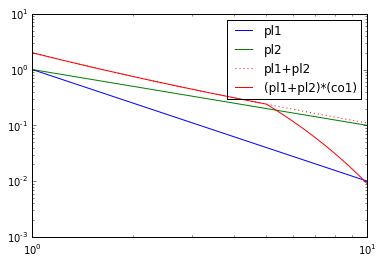

In [288]:
from astropy import units as u
from astropy import coordinates as coord

class xSpectralComponent():
    '''Spectral Component class:
    define the spectral component that can be used to build a model spectrum to use with the simulator
    author: nicola.omodei@stanford.edu
    '''
    def __init__(self,name):
        self.name=name
        self.degree=0
        self.angle=0
        self.f=None
        pass
    
    def powerlaw(self,C,gamma):
        'C is the normalization at 1keV'
        self.f=lambda x: C*pow(x,gamma)
        pass

    def highecut(self,foldE,cutoffE=0.0):
        'C is the normalization at 1keV'
        self.f=lambda x: exp(-sp.maximum(0.0,(x-cutoffE)/foldE))
        pass


    
    def __call__(self,x):
        return self.f(x)
    
    def __add__(self,other):
        
        newname='%s+%s'%(self.name,other.name)
        summed=xSpectralComponent(newname)
        summed.f=lambda x: self.f(x)+other.f(x)
        return summed

    def __mul__(self,other):    
        newname='(%s)*(%s)'%(self.name,other.name)
        multiplied=xSpectralComponent(newname)
        multiplied.f=lambda x: self.f(x)*other.f(x)
        return multiplied
    
    def polarization(self,degree,angle):
        self.degree=degree
        self.angle =angle
        
    def plot(self,x,*args, **kwargs):
        from matplotlib import pyplot as plt
        plt.plot(x,self.f(x),label=self.name,*args, **kwargs)
        pass
    
class xSource():
    '''Source class:
    name of the source can be automatically resolved by NED and SIMBAD
    astropy.coordinates handle coordinate transformations
    astropy.units define units for the different quantities
    
    author: nicola.omodei@stanford.edu
    '''
    def __init__(self,name,resolve_name=True):
        self.name=name
        if resolve_name: 
            try:
                self.coord=coord.SkyCoord.from_name(name)
            except:
                print 'WARNING [xSource]: Unable to find coordinates for name %s' % name 
                self.setLB(0,0)  
            pass
        else: self.setLB(0,0)
        self.components=sp.array([])
        
    def setSkyCord(self,coord):
        self.coord=coord

    def setRADec(self,ra,dec):
        self.setSkyCord(coord.SkyCoord(ra=ra*u.deg, dec=dec*u.deg, frame='fk5'))
    
    def setLB(self,l,b):
        self.setSkyCord(coord.SkyCoord(l=l*u.deg, b=b*u.deg, frame='galactic'))

    def getSetSkyCord(self): 
        return self.coord
    
    def getRADec(self): 
        return self.coord.fk5.ra.deg,self.coord.fk5.dec.deg
    
    def getLB(self): 
        return self.coord.galactic.l.deg,self.coord.galactic.b.deg
    
    def addComponent(self,component):
        print 'Component %s added' % component.name
        self.components=sp.append(self.components,component)
        pass

    

# EXAMPLE:
Crab=xSource('Crab',resolve_name=False)
Crab.setRADec(83.63309062468973, 22.014494786634714)

pl1 = xSpectralComponent('pl1')
pl2 = xSpectralComponent('pl2')
co1 = xSpectralComponent('co1')

pl1.powerlaw(1.0,-2)
pl2.powerlaw(1.0,-1)
pl3=pl1+pl2

co1.highecut(2.0,5.0)

synch=(pl1+pl2)*co1

xx=sp.linspace(1,10,100)
pl1.plot(xx)
pl2.plot(xx)
pl3.plot(xx,':')
synch.plot(xx,'r')

plt.xscale('log')
plt.yscale('log')
plt.legend()
synch.polarization(degree=0.17,angle=67)
Crab.addComponent(synch)

#Crab.AddComponent(...)
#Crab.TemporalProfile()

#CygX1=xSource('Cyg X-1')
#Crab.SetRADec(83.633083,22.014500)
#print Crab.getLB()
#print Crab.getRADec()
#l,b=Crab.getLB()
#Crab.setLB(l,b)
#print Crab.getLB()
#print Crab.getRADec()
#Angle=Crab.coord.separation(CygX1.coord)
#print Angle.deg


Done


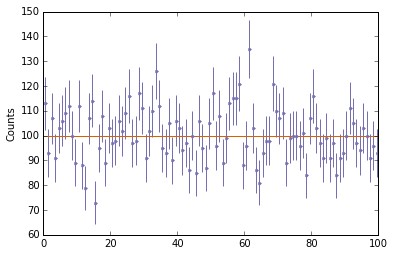

In [123]:
#1 case of a simple constant function:
lc=xLightCurve()
lc.Steady(100.0)
S=xSimulator(lc)
S.SetMinMax(0,100)
S.generate()
S.plot(100)

Done


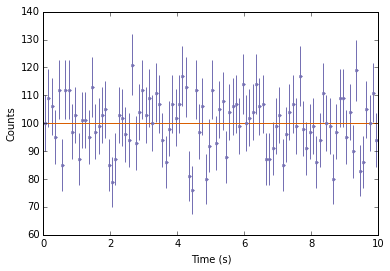

In [90]:
#1 case of a template (points in x and y):
tmin=0
tmax=10
x=sp.linspace(tmin,tmax,100)
y=1000.*sp.ones_like(x)
lc=xLightCurve()
lc.TemplateLightCurve(x,y)
S=xSimulator(lc)
S.SetMinMax(tmin,tmax)
S.generate()
S.plot(100)

Done


353

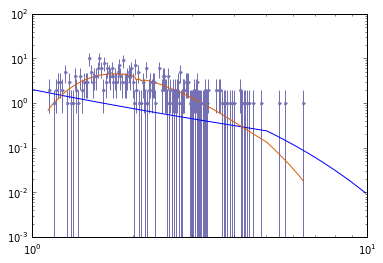

In [287]:
import astropy
from astropy.io import fits
class xAeff(object):
    def load_arf(self,myFile):
        hdulist = fits.open(myFile)
        data=hdulist['SPECRESP'].data
        self.ENERG_LO=data.field('ENERG_LO')
        self.ENERG_HI=data.field('ENERG_HI')
        self.SPECRESP=data.field('SPECRESP') # cm^2
        self.CentralEnergy=(self.ENERG_HI+self.ENERG_LO)*0.5        
        pass
    
    def convolve(self,dNdE):  
        # dNdE is in ph/cm^2/s/keV
        return self.CentralEnergy,self.SPECRESP*dNdE(self.CentralEnergy)
        

aeff=xAeff()
aeff.load_arf('../irf/fits/xipe_proposal.arf')


x,y=aeff.convolve(Crab.components[0])
f = interpolate.UnivariateSpline(x,y,k=1,s=0)
#plt.plot(x,Crab.components[0](x))

#plt.plot(x,y)
#plt.plot(x,f(x))
S=xSimulator(f,f.integral)
S.setMinMax(1,10)
S.generate()
S.plot()
plt.xscale('log')
plt.yscale('log')
S.nEvents

array([ 1.00548119,  1.00897353,  1.01402756, ...,  9.84914435,
        9.86744118,  9.88262894])

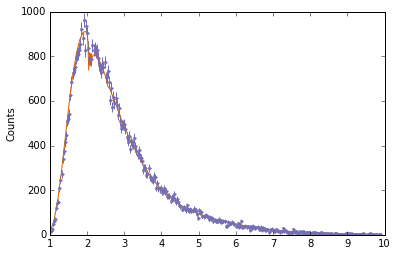

In [210]:
S.plot()
S.events

Done


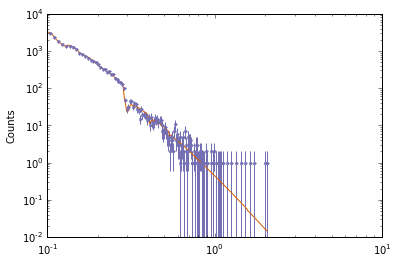

In [133]:
def dNdE(energy): 
    return 1.0*sp.power(energy,-4.8)

x,y=aeff.convolve(dNdE)
f = interpolate.UnivariateSpline(x,y,k=1,s=0)


#plt.plot(x,y)
#plt.plot(x,f(x))
S=xSimulator(f,f.integral)
S.SetMinMax(0.1,100)
S.generate()
S.plot()
plt.xscale('log')
plt.yscale('log')


In [136]:
len(S.events)

22779

In [242]:
x=sp.linspace(-5,5,10)

In [243]:
x

array([-5.        , -3.88888889, -2.77777778, -1.66666667, -0.55555556,
        0.55555556,  1.66666667,  2.77777778,  3.88888889,  5.        ])

In [278]:
Crab.components

array([], dtype=float64)